# Understanding how ViT works

## Setup

In [ ]:
!pip install -q wandb
!pip install -q -U git+https://github.com/huggingface/transformers.git

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 28.0 MB/s eta 0:00:00


In [ ]:
!nvidia-smi

Thu Oct 24 11:21:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              43W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import math
from tqdm import tqdm
from typing import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR100

from google.colab import userdata

In [ ]:
torch.cuda.empty_cache()

In [ ]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )

In [ ]:
os.environ["WANDB_API_KEY"] = userdata.get('WANDB_API_KEY')

In [ ]:
# Set a seed for reproducibility

def fix_torch_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

fix_torch_seed()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda')

# Training a ViT from scratch on image classification

## Load and preproc dataset

PyTorch transform: https://pytorch.org/vision/stable/transforms.html

DataLoader: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

Useful example: https://www.learnpytorch.io/08_pytorch_paper_replicating/

In [ ]:
# apply transformation
# use the openai processer as ref

# https://github.com/openai/CLIP/blob/main/clip/clip.py#L81
try:
    from torchvision.transforms import InterpolationMode
    BICUBIC = InterpolationMode.BICUBIC
except ImportError:
    BICUBIC = Image.BICUBIC

transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize(size=224, interpolation=BICUBIC, max_size=None, antialias=True),
    v2.CenterCrop(224),
    v2.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
])

In [ ]:
# Load the dataset and apply transformation
root = os.path.expanduser("~/.cache")
train = CIFAR100(root, download=True, train=True, transform=transforms)

100%|██████████| 169M/169M [00:01<00:00, 90.5MB/s]


Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache


In [ ]:
# Assuming train dataset is already loaded as shown in your code
# Select 10,000 random samples
num_samples = 30000
total_samples = len(train)

# Generate random indices for sampling
random_indices = torch.randperm(total_samples)[:num_samples]
subset_dataset = torch.utils.data.Subset(train, random_indices)

# Calculate split sizes
train_size = int(0.8 * num_samples)  # 80% for training
test_size = num_samples - train_size   # 20% for testidation

# Create the splits
train_subset, test_subset = torch.utils.data.random_split(subset_dataset, [train_size, test_size])

print(f"Original dataset size: {total_samples}")
print(f"Sampled dataset size: {len(subset_dataset)}")
print(f"Training set size: {len(train_subset)}")
print(f"Validation set size: {len(test_subset)}")

Original dataset size: 50000
Sampled dataset size: 30000
Training set size: 24000
Validation set size: 6000


OpenAI ViT processer

```
Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7801d6a3d750>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)
```

In [ ]:
transforms

Compose(
      ToImage()
      ToDtype(scale=True)
      Resize(size=[224], interpolation=InterpolationMode.BICUBIC, antialias=True)
      CenterCrop(size=(224, 224))
      Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711], inplace=False)
)

Note: a DataLoader returns a list[] containing the data and labels with shapes data (batch_size, C, H, W) and labels (batch_size)

In [ ]:
# original image shape x (C, H, W) --> C: channel H: height W: width
## gets turned into a sequence of 2D patches x_p (N, (P^2 C)) --> P: patch resolution N: resulting number of patches
## N is also the length of input sequence to the transformer
## where N = HW / P^2
## So x: (C, H, W) --> x_p: (N, (P^2 * C))
## need to apply this to a single image as a starter
# aim is to create a [196, 768] input tensor as per ViT paper

# Create example values
H = 224 # Height ("The training resolution is 224.")
W = 224 # Width
C = 3 # Channel
P = 16 # Patch

# Calculate N (number of patches)
N = int((H * W) / P**2)
print(f"Number of patches (N) with image height (H={H}), width (W={W}) and patch size (P={P}): {N}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


Image patches with CNNs per the original paper:

Hybrid Architecture. As an alternative to raw image patches, the input sequence can be formed
**from feature maps of a CNN (LeCun et al., 1989)**. In this hybrid model, the patch embedding
projection E (Eq. 1) is applied to patches extracted from a CNN feature map. As a special case,
the patches can have spatial size 1x1, which means that the input sequence is obtained by simply
flattening the spatial dimensions of the feature map and projecting to the Transformer dimension.
The classification input embedding and position embeddings are added as described above.

In [ ]:
# patches with Conv2d layer example

# where out_channels corresponds to the embedding dim that is to be passed to the Transformer encoder with kernel and stride size (16x16) to produce patches
conv2d_layer = nn.Conv2d(in_channels=3,
                         out_channels=768,
                         kernel_size=N,
                         stride=N,
                         padding=0)

flatten_layer = nn.Flatten(start_dim=2,
                           end_dim=3) # multiplies (dim 2 feature_map_height * dim 3 feature_map_width)

conv2d_layer_out = conv2d_layer(image.unsqueeze(0)) # add extra dim for batch_size
flatten_out = flatten_layer(conv2d_layer_out)

print(f"Original image shape: {image.unsqueeze(0).shape} --> [batch_size, channel, height, width]")
print(f"Conv2D output shape: {conv2d_layer_out.shape} --> [batch_size, hidden_size, feature_map_height, feature_map_width]")
print(f"Flatten output shape: {flatten_out.shape} --> [batch_size, hidden_size, number_of_patches]")
print(f"Permuting the flatten tensor: {torch.permute(flatten_out, (0, 2, 1)).size()} --> [batch_size, number_of_patches, hidden_size]")

Original image shape: torch.Size([1, 3, 224, 224]) --> [batch_size, channel, height, width]
Conv2D output shape: torch.Size([1, 768, 1, 1]) --> [batch_size, hidden_size, feature_map_height, feature_map_width]
Flatten output shape: torch.Size([1, 768, 1]) --> [batch_size, hidden_size, number_of_patches]
Permuting the flatten tensor: torch.Size([1, 1, 768]) --> [batch_size, number_of_patches, hidden_size]


## ViT implementation

The model essentially contains the following modules:

* Embedding layer

* LayerNorm layers

* Multi-head self-attention

* MLP layers

In [ ]:
## hyperparameter configs
from dataclasses import dataclass

@dataclass
class ViTConfig:
  # model hyperparameters
  # paper parameters (https://arxiv.org/abs/2010.11929) but we GPU-poor :(
  hidden_size: int = 768 # image patch embedding dim
  n_head: int = 6 # attention heads
  n_layer: int = 6 # layers inside a ViT block
  n_channels: int = 3 # number of channels for input images
  n_patches: int = 196 # since we are using a patch size of 16, using (H * W) / P**2 n_patches = 196 + learnable token = 197
  n_labels: int = 100 # number of labels in the dataset
  mlp_size: int = 1536 # mlp module size
  patch_size: int = 16 # kernal_size for CNN patching layer
  bias: bool = True # linear layer bias config

  # training config
  batch_size: int = 32
  dropout: int = 0.1
  learning_rate: float = 3e-4
  weight_decay: float = 0.1
  epochs: int = 20

# init config
config = ViTConfig()

In [ ]:
class ViTPatchEmbedding(nn.Module):
  def __init__(self, config):
    super().__init__()

    self.projection = nn.Conv2d(config.n_channels,
                                config.hidden_size,
                                kernel_size=config.patch_size,
                                stride=config.patch_size)
    self.flatten = nn.Flatten(start_dim=2, end_dim=3)
    self.learnable_parameter = nn.Parameter(torch.randn(config.batch_size,
                                                        1,
                                                        config.hidden_size),
                                            requires_grad=True)
    self.pos_embedding = nn.Parameter(torch.randn(config.batch_size,
                                                  config.n_patches + 1,
                                                  config.hidden_size),
                                      requires_grad=True)

  def forward(self, x):
    # (B, C, H, W) input tensor shape
    image_resolution = x.shape[-1]
    assert image_resolution % config.patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {config.patch_size}"
    x = self.projection(x)
    x = self.flatten(x)
    x = torch.permute(x, (0, 2, 1))
    x = torch.cat((self.learnable_parameter, x), dim=1)
    x = x + self.pos_embedding
    # (B, N, D) input tensor shape
    return x

class ViTAttention(nn.Module):
  def __init__(self, config):
    super().__init__()

    self.query = nn.Linear(config.hidden_size, config.hidden_size, bias=config.bias)
    self.key = nn.Linear(config.hidden_size, config.hidden_size, bias=config.bias)
    self.value = nn.Linear(config.hidden_size, config.hidden_size, bias=config.bias)
    self.dense = nn.Linear(config.hidden_size, config.hidden_size, bias=config.bias)
    self.dropout = nn.Dropout(config.dropout, inplace=False)

  def forward(self, x):
    # linear projections of q k v
    # (B, N, D)
    q = self.query(x)
    k = self.key(x)
    v = self.value(x)

    # compute attention
    attention = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
    attention = F.softmax(attention, dim=-1)
    attention = self.dropout(attention)
    z = attention @ v
    z = self.dense(z)

    return z

class ViTMultiHeadSelfAttention(nn.Module):
  def __init__(self, config):
    super().__init__()

    self.heads = nn.ModuleList([ViTAttention(config) for _ in range(config.n_head)])
    self.c_proj = nn.Linear(config.hidden_size * config.n_head, config.hidden_size, bias=config.bias)

  def forward(self, x):
    # (B, N, D)
    z = torch.cat([h(x) for h in self.heads], dim=-1) # (B, N, D * n_head)
    z = self.c_proj(z) # (B, N, D)
    return z

class ViTLayer(nn.Module):
  def __init__(self, config):
    super().__init__()

    self.layernorm_1 = nn.LayerNorm(config.hidden_size)
    self.msa = ViTMultiHeadSelfAttention(config)

    self.layernorm_2 = nn.LayerNorm(config.hidden_size)
    self.mlp = nn.Sequential(OrderedDict([
          ('linear1', nn.Linear(in_features=config.hidden_size,
                                out_features=config.mlp_size,
                                bias=config.bias)),
          ('gelu', nn.GELU()),
          ('dropout1', nn.Dropout(p=config.dropout)),
          ('linear2',nn.Linear(in_features=config.mlp_size,
                                out_features=config.hidden_size,
                                bias=config.bias)),
          ('dropout2', nn.Dropout(p=config.dropout))
        ]))

  def forward(self, x):
    # (B, N, D)
    x = x + self.msa(self.layernorm_1(x))
    x = x + self.mlp(self.layernorm_2(x))
    return x

class ViT(nn.Module):
  def __init__(self, config):
    super().__init__()

    self.patch_embedding = ViTPatchEmbedding(config)
    self.transformer_encoder_layers = nn.ModuleList([ViTLayer(config) for _ in range(config.n_layer)])
    self.layernorm = nn.LayerNorm(config.hidden_size)
    self.classifier = nn.Linear(in_features=config.hidden_size,
                                out_features=config.n_labels,
                                bias=config.bias)

  def forward(self, x):
    # (B, C, H, W)
    x = self.patch_embedding(x) # (B, N, D)
    for layer in self.transformer_encoder_layers:
      x = layer(x)
    x = self.layernorm(x)
    x = self.classifier(x[:, 0]) # get the classification logits

    return x

In [ ]:
# define model
vit = ViT(config).to(device)
print(round(sum(p.numel() for p in vit.parameters())/1e6, 1), 'M parameters')

126.0 M parameters


In [ ]:
# define optimizer
optimizer = torch.optim.Adam(vit.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
# setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
optimizer, loss_fn

(Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.0003
     maximize: False
     weight_decay: 0.1
 ),
 CrossEntropyLoss())

## Training ViT

### Setup WANDB run

In [ ]:
!wandb login

import wandb, os
wandb.login()

wandb_project = "vit-from-scratch"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

In [ ]:
!rm -r /content/wandb

rm: cannot remove '/content/wandb': No such file or directory


In [ ]:
# init wandb

# start a new wandb run to track this script
run = wandb.init(
    # set the wandb project where this run will be logged
    project="vit-from-scratch",
    name="ViT-cifar100-v1-125m", # change accoreding to run type

    # track hyperparameters and run metadata
    config={
        "hidden_size": 768,
        "n_head": 6,
        "n_layer": 6,
        "n_channels": 3,
        "n_patches": 197,
        "n_labels": 100,
        "mlp_size": 1536,
        "patch_size": 16,
        "bias": True,
        "batch_size": 4,
        "dropout": 0.1,
        "learning_rate": 3e-4,
        "weight_decay": 0.1,
        "epoch": 20,
        "training_data_size": 24000
    }
)

### Define dataloaders

In [ ]:
# define dataloaders
train_dataloader = DataLoader(train_subset, batch_size=config.batch_size, shuffle=True)

In [ ]:
for epoch in range(config.epochs):
    running_loss = 0.0
    num_batches = 0

    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # compute loss
        logits = vit(inputs)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        # accumulate loss
        running_loss += loss.item()
        num_batches += 1

        # Log batch-level metrics
        wandb.log({
            "batch_loss": loss.item(),
            "batch": i + epoch * len(train_dataloader)
        })

        # Optional: print batch progress
        if (i + 1) % 500 == 0:  # Print every 500 batches
            print(f'Epoch [{epoch + 1}/{config.epochs}], Batch [{i + 1}/{len(train_dataloader)}]')

    # Calculate and log epoch-level statistics
    epoch_loss = running_loss / num_batches
    print(f'Epoch [{epoch + 1}/{config.epochs}] Average Loss: {epoch_loss:.3f}')

    # Log epoch-level metrics
    wandb.log({
        "epoch": epoch + 1,
        "epoch_loss": epoch_loss,
        "learning_rate": optimizer.param_groups[0]['lr']
    })

Epoch [1/20], Batch [500/750]
Epoch [1/20] Average Loss: 4.667
Epoch [2/20], Batch [500/750]
Epoch [2/20] Average Loss: 4.638
Epoch [3/20], Batch [500/750]
Epoch [3/20] Average Loss: 4.620
Epoch [4/20], Batch [500/750]
Epoch [4/20] Average Loss: 4.611
Epoch [5/20], Batch [500/750]
Epoch [5/20] Average Loss: 4.607
Epoch [6/20], Batch [500/750]
Epoch [6/20] Average Loss: 4.605
Epoch [7/20], Batch [500/750]
Epoch [7/20] Average Loss: 4.605
Epoch [8/20], Batch [500/750]
Epoch [8/20] Average Loss: 4.605
Epoch [9/20], Batch [500/750]
Epoch [9/20] Average Loss: 4.605
Epoch [10/20], Batch [500/750]
Epoch [10/20] Average Loss: 4.605
Epoch [11/20], Batch [500/750]
Epoch [11/20] Average Loss: 4.605
Epoch [12/20], Batch [500/750]
Epoch [12/20] Average Loss: 4.605
Epoch [13/20], Batch [500/750]
Epoch [13/20] Average Loss: 4.605
Epoch [14/20], Batch [500/750]
Epoch [14/20] Average Loss: 4.605
Epoch [15/20], Batch [500/750]
Epoch [15/20] Average Loss: 4.605
Epoch [16/20], Batch [500/750]
Epoch [16/20

In [ ]:
SAVE_MODEL_PATH = "cifar100-v1-125m.pt"
torch.save(vit.state_dict(), SAVE_MODEL_PATH)

In [ ]:
# upload artifact to wandb
artifact = wandb.Artifact("ViT-cifar100-v1-125m", type="model")
artifact.add_file(SAVE_MODEL_PATH)
run.log_artifact(artifact)

<Artifact ViT-cifar100-v1-125m>

In [ ]:
run.finish()

## Inference

In [ ]:
test_dataloader = DataLoader(test_subset, batch_size=config.batch_size, shuffle=True)

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
classes = tuple(train.classes)

In [ ]:
len(classes)

100

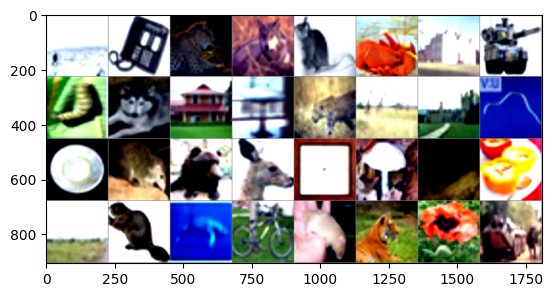

GroundTruth:  cloud telephone leopard wolf  mouse lobster castle tank  caterpillar wolf  house lamp  leopard plain castle worm  plate shrew bear  kangaroo clock mushroom forest sweet_pepper plain beaver whale bicycle mouse tiger poppy tank 


In [ ]:
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(32)))

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        if images.shape[0] != 32:
          print(f"Image batch shape {images.shape[0]} is mismatched. Must be 64")
          continue
        outputs = vit(images)
        outputs = F.softmax(outputs, dim=-1)
        #print(outputs.data)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 2000 test images: {100 * correct // total} %')

Image batch shape 16 is mismatched. Must be 64
Accuracy of the network on the 2000 test images: 1 %


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if images.shape[0] != 32:
          print(f"Image batch shape {images.shape[0]} is mismatched. Must be 64")
          continue
        outputs = vit(images)
        outputs = F.softmax(outputs, dim=-1)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Image batch shape 16 is mismatched. Must be 64
Accuracy for class: apple is 0.0 %
Accuracy for class: aquarium_fish is 0.0 %
Accuracy for class: baby  is 0.0 %
Accuracy for class: bear  is 0.0 %
Accuracy for class: beaver is 0.0 %
Accuracy for class: bed   is 0.0 %
Accuracy for class: bee   is 0.0 %
Accuracy for class: beetle is 0.0 %
Accuracy for class: bicycle is 0.0 %
Accuracy for class: bottle is 0.0 %
Accuracy for class: bowl  is 0.0 %
Accuracy for class: boy   is 0.0 %
Accuracy for class: bridge is 0.0 %
Accuracy for class: bus   is 0.0 %
Accuracy for class: butterfly is 0.0 %
Accuracy for class: camel is 0.0 %
Accuracy for class: can   is 0.0 %
Accuracy for class: castle is 0.0 %
Accuracy for class: caterpillar is 0.0 %
Accuracy for class: cattle is 0.0 %
Accuracy for class: chair is 0.0 %
Accuracy for class: chimpanzee is 0.0 %
Accuracy for class: clock is 0.0 %
Accuracy for class: cloud is 0.0 %
Accuracy for class: cockroach is 0.0 %
Accuracy for class: couch is 0.0 %
Accuracy

As it is evident from the inference results This experiment still needs more work :)